In [1]:
!pip install tensorflow==2.12.0


## 트랜스포머(Transformer)
트랜스포머(Transformer)는 2017년 구글이 발표한 논문인 "Attention is all you need"에서 나온 모델로 기존의 seq2seq의 구조인 인코더-디코더를 따르면서도, 논문의 이름처럼 어텐션(Attention)만으로 구현한 모델입니다. 이 모델은 RNN을 사용하지 않고, 인코더-디코더 구조를 설계하였음에도 번역 성능에서도 RNN보다 우수한 성능을 보여주었습니다.

당장 구현에 관심이 없다면 코드 부분만 스킵해서 이론만 읽으셔도 됩니다.

트랜스포머 전체 코드는 아래의 링크에 공유합니다.
깃허브 링크 : https://github.com/ukairia777/tensorflow-transformer

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


### 1.기존의 seq2seq 모델의 한계
트랜스포머에 대해서 배우기 전에 기존의 seq2seq를 상기해봅시다. 기존의 seq2seq 모델은 인코더-디코더 구조로 구성되어져 있었습니다. 여기서 인코더는 입력 시퀀스를 하나의 벡터 표현으로 압축하고, 디코더는 이 벡터 표현을 통해서 출력 시퀀스를 만들어냈습니다. 하지만 이러한 구조는 인코더가 입력 시퀀스를 하나의 벡터로 압축하는 과정에서 입력 시퀀스의 정보가 일부 손실된다는 단점이 있었고, 이를 보정하기 위해 어텐션이 사용되었습니다. 그런데 어텐션을 RNN의 보정을 위한 용도로서 사용하는 것이 아니라 어텐션만으로 인코더와 디코더를 만들어보면 어떨까요?

### 2. 트랜스포머의 주요 하이퍼파라미터
시작에 앞서 트랜스포머의 하이퍼파라미터를 정의합니다. 각 하이퍼파라미터의 의미에 대해서는 뒤에서 설명하기로하고, 여기서는 트랜스포머에는 이러한 하이퍼파라미터가 존재한다는 정도로만 이해해보겠습니다. 아래에서 정의하는 수치는 트랜스포머를 제안한 논문에서 사용한 수치로 하이퍼파라미터는 사용자가 모델 설계시 임의로 변경할 수 있는 값들입니다.


트랜스포머의 인코더와 디코더에서의 정해진 입력과 출력의 크기를 의미합니다. 임베딩 벡터의 차원 또한
d_model이며, 각 인코더와 디코더가 다음 층의 인코더와 디코더로 값을 보낼 때에도 이 차원을 유지합니다. 논문에서는 512입니다.


num_layer = 6: 트랜스포머에서 하나의 인코더와 디코더를 층으로 생각하였을 때, 트랜스포머 모델에서 인코더와 디코더가 총 몇 층으로 구성되었는지를 의미합니다. 논문에서는 인코더와 디코더를 각각 총 6개 쌓았습니다.


num_heads = 8: 트랜스포머에서는 어텐션을 사용할 때, 한 번 하는 것 보다 여러 개로 분할해서 병렬로 어텐션을 수행하고 결과값을 다시 하나로 합치는 방식을 택했습니다. 이때 이 병렬의 개수를 의미합니다.

### 3. 포지셔널 인코딩(Positional Encodings)
트랜스포머의 내부를 이해하기 전 우선 트랜스포머의 입력에 대해서 알아보겠습니다. RNN이 자연어 처리에서 유용했던 이유는 단어의 위치에 따라 단어를 순차적으로 입력받아서 처리하는 RNN의 특성으로 인해 각 단어의 위치 정보(position information)를 가질 수 있다는 점에 있었습니다.

하지만 트랜스포머는 단어 입력을 순차적으로 받는 방식이 아니므로 단어의 위치 정보를 다른 방식으로 알려줄 필요가 있습니다. 트랜스포머는 단어의 위치 정보를 얻기 위해서 각 단어의 임베딩 벡터에 위치 정보들을 더하여 모델의 입력으로 사용하는데, 이를 포지셔널 인코딩(positional encoding)이라고 합니다.

포지셔널 인코딩 값들은 어떤 값이기에 위치 정보를 반영해줄 수 있는 것일까요? 트랜스포머는 위치 정보를 가진 값을 만들기 위해서 아래의 두 개의 함수를 사용합니다.

사인 함수와 코사인 함수의 그래프를 상기해보면 요동치는 값의 형태를 생각해볼 수 있는데, 트랜스포머는 사인 함수와 코사인 함수의 값을 임베딩 벡터에 더해주므로서 단어의 순서 정보를 더하여 줍니다.

, 임베딩 벡터와 포지셔널 인코딩의 덧셈은 사실 임베딩 벡터가 모여 만들어진 문장 행렬과 포지셔널 인코딩 행렬의 덧셈 연산을 통해 이루어진다는 점을 이해해야 합니다.

In [3]:
class PositionalEncoding(tf.keras.layers.Layer):
  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2*(i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position = tf.range(position, dtype= tf.float32)[:, tf.newaxis],
        i = tf.range(d_model, dtype = tf.float32)[tf.newaxis, :],
        d_model=d_model
    )
    # 배열의 짝수 인덱스(2i)에는 사인 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스(2i+1)에는 코사인 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    angle_rads = np.zeros(angle_rads.shape)
    angle_rads[:, 0::2] = sines
    angle_rads[:, 1::2] = cosines
    pos_encoding = tf.constant(angle_rads)
    pos_encoding = pos_encoding[tf.newaxis, ...]

    print(pos_encoding.shape)
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]


50 × 128의 크기를 가지는 포지셔널 인코딩 행렬을 시각화하여 어떤 형태를 가지는지 확인해봅시다. 이는 입력 문장의 단어가 50개이면서, 각 단어가 128차원의 임베딩 벡터를 가질 때 사용할 수 있는 행렬입니다.

(1, 50, 128)


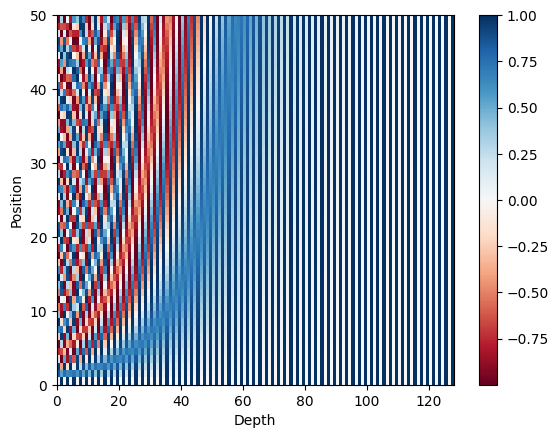

In [4]:
# 문장의 길이 50, 임베딩 벡터의 차원 128
sample_pos_encoding = PositionalEncoding(50, 128)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 128))
plt.ylabel('Position')
plt.colorbar()
plt.show()

트랜스포머에서 사용되는 세 가지의 어텐션에 대해서 간단히 정리해봅시다. 지금은 큰 그림을 이해하는 것에만 집중합니다.

### 4. 스케일드 닷-프로덕트 어텐션 구현하기

In [5]:
def scaled_dot_product_attention(query, key, value, mask):
  # query 크기 : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
  # key 크기 : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
  # value 크기 : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
  # padding_mask : (batch_size, 1, 1, key의 문장 길이)

  # Q와 K의 곱. 어텐션 스코어 행렬.
  matmul_qk = tf.matmul(query, key, transpose_b = True)
  # transpose_b = True -> 두 번째 인자인 key 텐서를 곱하기 전에 전치(transpose)


  # 스케일링
  # dk의 루트값으로 나눠준다.
  # dk는 Q벡터와 K벡터의 차원
  depth = tf.cast(tf.shape(key)[-1], tf.float32) # 데이터 타입 변환
  logits = matmul_qk / tf.math.sqrt(depth)

  # 마스킹. 어텐션 스코어 행렬의 마스킹 할 위치에 매우 작은 음수값을 넣는다.
  # 매우 작은 값이므로 소프트맥스 함수를 지나면 행렬의 해당 위치의 값은 0이 된다.
  if mask is not None:
    logits += (mask * -1e9)

  # 소프트맥스 함수는 마지막 차원인 key의 문장 길이 방향으로 수행된다.
  # attention weight : (batch_size, num_heads, query의 문장 길이, key의 문장 길이)
  attention_weights = tf.nn.softmax(logits, axis = -1)

  # output : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
  output = tf.matmul(attention_weights, value)
  return output, attention_weights

Q행렬과 K행렬을 전치한 행렬을 곱하고, 소프트맥스 함수를 사용하여 어텐션 분포 행렬을 얻은 뒤에 V행렬과 곱합니다. 코드에서 mask가 사용되는 if문은 아직 배우지 않은 내용으로 지금은 무시합니다.

scaled_dot_product_attention 함수가 정상 작동하는지 테스트를 해보겠습니다. 우선 temp_q, temp_k, temp_v라는 임의의 Query, Key, Value 행렬을 만들고, 이를 scaled_dot_product_attention 함수에 입력으로 넣어 함수가 리턴하는 값을 출력해보겠습니다.

In [6]:
# 임의의 Query, Key, Value인 Q, K, V 행렬 생성
np.set_printoptions(suppress=True)

# tf.constant는 변하지 않는 상수 텐서를 생성할 때 사용하는 함수
temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)

여기서 주목할 점은 Query에 해당하는 temp_q의 값 [0, 10, 0]은 Key에 해당하는 temp_k의 두번째 값 [0, 10, 0]과 일치한다는 점입니다. 그렇다면 어텐션 분포와 어텐션 값은 과연 어떤 값이 나올까요?

In [7]:
# 함수 실행
temp_out, temp_attn = scaled_dot_product_attention(temp_q, temp_k, temp_v, None)
print(temp_attn) # 어텐션 분포(어텐션 가중치의 나열)
print(temp_out) # 어텐션 값


tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


Query는 4개의 Key값 중 두번째 값과 일치하므로 어텐션 분포는 [0, 1, 0, 0]의 값을 가지며 결과적으로 Value의 두번째 값인 [10, 0]이 출력되는 것을 확인할 수 있습니다. 이번에는 Query의 값만 다른 값으로 바꿔보고 함수를 실행해봅시다. 이번에 사용할 Query값 [0, 0, 10]은 Key의 세번째 값과, 네번째 값 두 개의 값 모두와 일치하는 값입니다.

In [8]:
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)
temp_out, temp_attn = scaled_dot_product_attention(temp_q, temp_k, temp_v, None)
print(temp_attn) # 어텐션 분포(어텐션 가중치의 나열)
print(temp_out) # 어텐션 값


tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


Query의 값은 Key의 세번째 값과 네번째 값 두 개의 값과 모두 유사하다는 의미에서 어텐션 분포는 [0, 0, 0.5, 0.5]의 값을 가집니다. 결과적으로 나오는 값 [550, 5.5]는 Value의 세번째 값 [100, 5]에 0.5를 곱한 값과 네번째 값 [1000, 6]에 0.5를 곱한 값의 원소별 합입니다. 이번에는 하나가 아닌 3개의 Query의 값을 함수의 입력으로 사용해보겠습니다.

In [9]:
temp_q = tf.constant([[0, 0, 10], [0, 10, 0], [10, 10, 0]], dtype=tf.float32)  # (3, 3)
temp_out, temp_attn = scaled_dot_product_attention(temp_q, temp_k, temp_v, None)
print(temp_attn) # 어텐션 분포(어텐션 가중치의 나열)
print(temp_out) # 어텐션 값


tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


### 5. 멀티 헤드 어텐션(Multi-head Attention)
앞서 배운 어텐션에서는 d_model
의 차원을 가진 단어 벡터를 num_heads
로 나눈 차원을 가지는 Q, K, V벡터로 바꾸고 어텐션을 수행하였습니다. 논문 기준으로는 512의 차원의 각 단어 벡터를 8로 나누어 64차원의 Q, K, V 벡터로 바꾸어서 어텐션을 수행한 셈인데, 이제 num_heads
의 의미와 왜 d_model
의 차원을 가진 단어 벡터를 가지고 어텐션을 하지 않고 차원을 축소시킨 벡터로 어텐션을 수행하였는지 이해해보겠습니다.

멀티 헤드 어텐션에서는 크게 두 종류의 가중치 행렬이 나왔습니다. Q, K, V 행렬을 만들기 위한 가중치 행렬인 WQ, WK, WV 행렬과 바로 어텐션 헤드들을 연결(concatenation) 후에 곱해주는 WO 행렬입니다. 가중치 행렬을 곱하는 것을 구현 상에서는 입력을 전결합층. 즉, 밀집층(Dense layer)을 지나게 하여 구현합니다. 케라스 코드 상으로 지금까지 사용해왔던 Dense()에 해당됩니다.

멀티 헤드 어텐션의 구현은 크게 다섯 가지 파트로 구성됩니다.

1. WQ, WK, WV에 해당하는 d_model 크기의 밀집층(Dense layer)을 지나게한다.
2. 지정된 헤드 수(num_heads)만큼 나눈다(split).
3. 스케일드 닷 프로덕트 어텐션.
4. 나눠졌던 헤드들을 연결(concatenatetion)한다.
5. WO에 해당하는 밀집층을 지나게 한다.

이론으로 설명할 때보다 심플하게 구성되었는데 결국 근본적으로 동일한 내용입니다.

In [10]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name = "multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0
    # assert 함수는 조건이 반드시 참(True)이어야 한다는 것을 보장하고, 그렇지 않으면 프로그램을 즉시 중단시키는 디버깅 도구

    # d_model을 num_heads로 나눈 값.
    # 논문 기준 : 64
    self.depth = d_model // self.num_heads

    # WQ, WK, WV에 해당하는 밀집층 정의
    self.query_dense = tf.keras.layers.Dense(units = d_model)
    self.key_dense = tf.keras.layers.Dense(units = d_model)
    self.value_dense = tf.keras.layers.Dense(units = d_model)

    # WO에 해당하는 밀집층 정의
    self.dense = tf.keras.layers.Dense(units = d_model)

  # (batch, 512, 8, 64) -> (batch, 8, 512, 64)
  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape = (batch_size, -1, self.num_heads, self.depth)
    )


    return tf.transpose(inputs, perm=[0,2,1,3])

  # num_heads 개수만큼 q,k,v를 split하는 함수
  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
    batch_size = tf.shape(query)[0]

  # 1. WQ, WK, WV에 해당하는 밀집층 지나기
  # q : (batch_size, query의 문장 길이, d_model)
  # k : (batch_size, key의 문장 길이, d_model)
  # v : (batch_size, value의 문장 길이, d_model)
  # 참고) 인코더(k, v)-디코더(q) 어텐션에서는 query 길이와 key, value의 길이는 다를 수 있다.

    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

  # 2. 헤드 나누기
  # q : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)->(batch, 8, 512, 64)
  # k : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)->(batch, 8, 512, 64)
  # v : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)->(batch, 8, 512, 64)
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

  # 3. 스케일드 닷 프로덕트 어텐션. 앞서 구현한 함수 사용.
  # (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)

  # (batch_size, query의 문장 길이, num_heads, d_model/num_heads) ->(batch, 512, 8, 64)
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

  # 4. 헤드 연결(concatenate)하기
  # (batch_size, query의 문장 길이, d_model) ->(batch, 512, 512)
    concat_attention = tf.reshape(scaled_attention,
                                (batch_size, -1, self.d_model))

  # 5. WO에 해당하는 밀집층 지나기
  # (batch_size, query의 문장 길이, d_model)
    outputs = self.dense(concat_attention)

    return outputs

 앞서 구현한 스케일드 닷 프로덕트 어텐션 함수 내부를 보면 mask라는 값을 인자로 받아서, 이 mask값에다가 -1e9라는 아주 작은 음수값을 곱한 후 어텐션 스코어 행렬에 더해주고 있습니다. 이 연산의 정체는 무엇일까요?
 이는 입력 문장에 PAD 토큰이 있을 경우 어텐션에서 사실상 제외하기 위한 연산입니다.

 트랜스포머에서는 Key의 경우에 PAD 토큰이 존재한다면 이에 대해서는 유사도를 구하지 않도록 마스킹(Masking)을 해주기로 했습니다. 여기서 마스킹이란 어텐션에서 제외하기 위해 값을 가린다는 의미입니다. 어텐션 스코어 행렬에서 행에 해당하는 문장은 Query이고, 열에 해당하는 문장은 Key입니다. 그리고 Key에 PAD가 있는 경우에는 해당 열 전체를 마스킹을 해줍니다.

In [11]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, key의 문장 길이)
  return mask[:, tf.newaxis, tf.newaxis, :]


In [12]:
print(create_padding_mask(tf.constant([[1, 21, 777, 0, 0]])))

tf.Tensor([[[[0. 0. 0. 1. 1.]]]], shape=(1, 1, 1, 5), dtype=float32)


위 벡터를 통해서 1의 값을 가진 위치의 열을 어텐션 스코어 행렬에서 마스킹하는 용도로 사용할 수 있습니다. 위 벡터를 스케일드 닷 프로덕트 어텐션의 인자로 전달하면, 스케일드 닷 프로덕트 어텐션에서는 위 벡터에다가 매우 작은 음수값인 -1e9를 곱하고, 이를 행렬에 더해주어 해당 열을 전부 마스킹합니다.

첫번째 서브층인 멀티 헤드 어텐션을 구현해보았습니다. 앞서 인코더는 두 개의 서브 서브층(sublayer)으로 나뉘어진다고 언급한 적이 있는데, 두번째 서브층인 포지션-와이즈 피드 포워드 신경망에 대해서 알아보겠습니다.

###6. 포지션-와이즈 피드 포워드 신경망
지금은 인코더를 설명하고 있지만, 포지션 와이즈 FFNN은 인코더와 디코더에서 공통적으로 가지고 있는 서브층입니다. 포지션-와이즈 FFNN는 쉽게 말하면 완전 연결 FFNN(Fully-connected FFNN)이라고 해석할 수 있습니다. 앞서 인공 신경망은 결국 벡터와 행렬 연산으로 표현될 수 있음을 배웠습니다. 아래는 포지션 와이즈 FFNN의 수식을 보여줍니다.

FFNN(x) = MAX(0, xW1 + b)W2 + b2

x는 앞서 멀티 헤드 어텐션의 결과로 나온
(seq_lenm, d_model)의 크기를 가지는 행렬을 말합니다. 가중치 행렬 W1
은
(d_model, dff)의 크기를 가지고, 가중치 행렬
은 W2
의 (dff, d_model)크기를 가집니다. 논문에서 은닉층의 크기인
는 앞서 하이퍼파라미터를 정의할 때 언급했듯이 2,048의 크기를 가집니다.

### 잔차 연결(Residual connection)과 층 정규화(Layer normalization)
인코더의 두 개의 서브층에 대해서 이해하였다면 인코더에 대한 설명은 거의 끝났습니다! 트랜스포머에서는 이러한 두 개의 서브층을 가진 인코더에 추가적으로 사용하는 기법이 있는데, 바로 Add & Norm입니다. 더 정확히는 잔차 연결(residual connection)과 층 정규화(layer normalization)를 의미합니다.

위의 그림은 앞서 Position-wise FFNN를 설명할 때 사용한 앞선 그림에서 화살표와 Add & Norm(잔차 연결과 정규화 과정)을 추가한 그림입니다. 추가된 화살표들은 서브층 이전의 입력에서 시작되어 서브층의 출력 부분을 향하고 있는 것에 주목합시다. 추가된 화살표가 어떤 의미를 갖고 있는지는 잔차 연결과 층 정규화를 배우고 나면 이해할 수 있습니다.

잔차 연결은 서브층의 입력과 출력을 더하는 것을 말합니다. 앞서 언급했듯이 트랜스포머에서 서브층의 입력과 출력은 동일한 차원을 갖고 있으므로, 서브층의 입력과 서브층의 출력은 덧셈 연산을 할 수 있습니다.

F(x) = Multi head input + Multi head output

### 층 정규화(Layer Normalization)
층 정규화는 텐서의 마지막 차원에 대해서 평균과 분산을 구하고, 이를 가지고 어떤 수식을 통해 값을 정규화하여 학습을 돕습니다. 여기서 텐서의 마지막 차원이란 것은 트랜스포머에서는 d_model
 차원을 의미합니다.

 층 정규화의 수식을 알아봅시다. 여기서는 층 정규화를 두 가지 과정으로 나누어서 설명하겠습니다. 첫번째는 평균과 분산을 통한 정규화, 두번째는 감마와 베타를 도입하는 것입니다.

### 인코더 구하기
지금까지 배운 내용을 바탕으로 인코더를 구현한 코드는 다음과 같습니다. 인코더의 입력으로 들어가는 문장에는 패딩이 있을 수 있으므로, 어텐션 시 패딩 토큰을 제외하도록 패딩 마스크를 사용합니다. 이는 MultiHeadAttention 함수의 mask의 인자값으로 padding_mask가 사용되는 이유입니다. 인코더는 총 두 개의 서브층으로 이루어지는데, 멀티 헤드 어텐션과 피드 포워드 신경망입니다. 각 서브층 이후에는 드롭 아웃, 잔차 연결과 층 정규화가 수행됩니다.

In [13]:
def encoder_layer(dff, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 인코더는 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 멀티-헤드 어텐션 (첫번째 서브층 / 셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
          'mask': padding_mask # 패딩 마스크 사용
      })

  # 드롭아웃 + 잔차 연결과 층 정규화
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)

  # x^ik = xik-평균 / sqrt(분산 + epslion)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 포지션 와이즈 피드 포워드 신경망 (두번째 서브층)
  # FFNN(x) = MAX(0, x * W1 + b1)W2 +b2
  outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 드롭아웃 + 잔차 연결과 층 정규화
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

위 코드는 하나의 인코더 블록. 즉, 하나의 인코더 층을 구현하는 코드입니다. 실제로 트랜스포머는 num_layers 개수만큼의 인코더 층을 사용하므로 이를 여러번 쌓는 코드를 별도 구현해줄 필요가 있습니다.

### 인코더 쌓기
지금까지 인코더 층의 내부 아키텍처에 대해서 이해해보았습니다. 이러한 인코더 층을 num_layers개만큼 쌓고, 마지막 인코더 층에서 얻는 (seq_len, d_model) 크기의 행렬을 디코더로 보내주므로서 트랜스포머 인코더의 인코딩 연산이 끝나게 됩니다. 아래의 코드는 인코더 층을 num_layers개만큼 쌓는 코드입니다.

In [14]:
def encoder(vocab_size, num_layers, dff,
            d_model, num_heads, dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 인코더는 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 포지셔널 인코딩 + 드롭아웃
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # 인코더를 num_layers개 쌓기
  for i in range(num_layers):
    outputs = encoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
        dropout=dropout, name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

### 인코더에서 디코더로
지금까지 인코더에 대해서 정리해보았습니다. 이렇게 구현된 인코더는 총
num_layer만큼의 층 연산을 순차적으로 한 후에 마지막 층의 인코더의 출력을 디코더에게 전달합니다. 인코더 연산이 끝났으면 디코더 연산이 시작되어 디코더 또한
num_layer만큼의 연산을 하는데, 이때마다 인코더가 보낸 출력을 각 디코더 층 연산에 사용합니다. 디코더에 대해서 이해해봅시다.

디코더도 인코더와 동일하게 임베딩 층과 포지셔널 인코딩을 거친 후의 문장 행렬이 입력됩니다. 트랜스포머 또한 seq2seq와 마찬가지로 교사 강요(Teacher Forcing)을 사용하여 훈련되므로 학습 과정에서 디코더는 번역할 문장에 해당되는 sos je suis étudiant의 문장 행렬을 한 번에 입력받습니다. 그리고 디코더는 이 문장 행렬로부터 각 시점의 단어를 예측하도록 훈련됩니다.

여기서 문제가 있습니다. seq2seq의 디코더에 사용되는 RNN 계열의 신경망은 입력 단어를 매 시점마다 순차적으로 입력받으므로 다음 단어 예측에 현재 시점을 포함한 이전 시점에 입력된 단어들만 참고할 수 있습니다. 반면, 트랜스포머는 문장 행렬로 입력을 한 번에 받으므로 현재 시점의 단어를 예측하고자 할 때, 입력 문장 행렬로부터 미래 시점의 단어까지도 참고할 수 있는 현상이 발생합니다. 가령, suis를 예측해야 하는 시점이라고 해봅시다. RNN 계열의 seq2seq의 디코더라면 현재까지 디코더에 입력된 단어는 sos와 je뿐일 것입니다. 반면, 트랜스포머는 이미 문장 행렬로 sos je suis étudiant를 입력받았습니다.

이를 위해 트랜스포머의 디코더에서는 현재 시점의 예측에서 현재 시점보다 미래에 있는 단어들을 참고하지 못하도록 룩-어헤드 마스크(look-ahead mask)를 도입했습니다. 직역하면 '미리보기에 대한 마스크'입니다.

룩-어헤드 마스크(look-ahead mask)는 디코더의 첫번째 서브층에서 이루어집니다. 디코더의 첫번째 서브층인 멀티 헤드 셀프 어텐션 층은 인코더의 첫번째 서브층인 멀티 헤드 셀프 어텐션 층과 동일한 연산을 수행합니다. 오직 다른 점은 어텐션 스코어 행렬에서 마스킹을 적용한다는 점만 다릅니다

마스킹 된 후의 어텐션 스코어 행렬의 각 행을 보면 자기 자신과 그 이전 단어들만을 참고할 수 있음을 볼 수 있습니다. 그 외에는 근본적으로 셀프 어텐션이라는 점과, 멀티 헤드 어텐션을 수행한다는 점에서 인코더의 첫번째 서브층과 같습니다.

룩-어헤드 마스크의 구현에 대해 알아봅시다. 룩-어헤드 마스크는 패딩 마스크와 마찬가지로 앞서 구현한 스케일드 닷 프로덕트 어텐션 함수에 mask라는 인자로 전달됩니다. 패딩 마스킹을 써야하는 경우에는 스케일드 닷 프로덕트 어텐션 함수에 패딩 마스크를 전달하고, 룩-어헤드 마스킹을 써야하는 경우에는 스케일드 닷 프로덕트 어텐션 함수에 룩-어헤드 마스크를 전달합니다.

트랜스포머에는 총 세 가지 어텐션이 존재하며, 모두 멀티 헤드 어텐션을 수행하고, 멀티 헤드 어텐션 함수 내부에서 스케일드 닷 프로덕트 어텐션 함수를 호출하는데 각 어텐션 시 함수에 전달하는 마스킹은 다음과 같습니다.

- 인코더의 셀프 어텐션 : 패딩 마스크를 전달
- 디코더의 첫번째 서브층인 마스크드 셀프 어텐션 : 룩-어헤드 마스크를 전달 <-- 지금 설명하고 있음.
- 디코더의 두번째 서브층인 인코더-디코더 어텐션 : 패딩 마스크를 전달

이때 룩-어헤드 마스크를 한다고해서 패딩 마스크가 불필요한 것이 아니므로 룩-어헤드 마스크는 패딩 마스크를 포함하도록 구현합니다. 룩-어헤드 마스크를 구현하는 방법은 패딩 마스크 때와 마찬가지로 마스킹을 하고자 하는 위치에는 1을, 마스킹을 하지 않는 위치에는 0을 리턴하도록 합니다.

In [15]:
# 디코더의 첫번째 서브층에서 미래 토큰을 mask하는 함수
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1] # 입력 시퀀스의 길이 추출

  # tf.linalg.band_part():하삼각 행렬만 남기고 나머지는 0으로 만듦
  # tf.ones(): 정사각형 행렬 생성 (모든 값이 1)
  look_ahead_mask = 1- tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)

  # Look-ahead 마스크와 패딩 마스크를 결합 (둘 중 하나라도 마스킹되면 1)
  return tf.maximum(look_ahead_mask, padding_mask)

In [16]:
print(create_look_ahead_mask(tf.constant([[1, 2, 0, 4, 5]])))


tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 0. 1.]
   [0. 0. 1. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


### 디코더의 두번째 서브층: 인코더-디코더 어텐션
디코더의 두번째 서브층에 대해서 이해해봅시다. 디코더의 두번째 서브층은 멀티 헤드 어텐션을 수행한다는 점에서는 이전의 어텐션들(인코더와 디코더의 첫번째 서브층)과는 공통점이 있으나 이번에는 셀프 어텐션이 아닙니다.

셀프 어텐션은 Query, Key, Value가 같은 경우를 말하는데, 인코더-디코더 어텐션은 Query가 디코더인 행렬인 반면, Key와 Value는 인코더 행렬이기 때문입니다. 다시 한 번 각 서브층에서의 Q, K, V의 관계를 정리해봅시다.

- **인코더의 첫번째 서브층** : Query = Key = Value

- **디코더의 첫번째 서브층** : Query = Key = Value

- **디코더의 두번째 서브층** : Query : 디코더 행렬 / Key = Value : 인코더 행렬

각각 Key와 Value는 인코더의 마지막 층에서 온 행렬로부터 얻습니다. 반면 Query는 디코더의 첫번째 서브층의 결과 행렬로부터 얻는다는 점이 다릅니다. Query가 디코더 행렬, Key가 인코더 행렬일 때, 어텐션 스코어 행렬을 구합니다.

그 외에 멀티 헤드 어텐션을 수행하는 과정은 다른 어텐션들과 같습니다.

In [17]:
def decoder_layer(dff, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name = "inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name = "encoder_outputs")

  # 룩어헤드 마스크(첫번째 서브층)
  look_ahead_mask = tf.keras.Input(shape=(1, None, None), name= "look_ahead_mask")

  # 패딩 마스크(두번째 서브층)
  padding_mask = tf.keras.Input(shape= (1, 1, None), name="padding_mask")

  # 멀티 헤드 어텐션 (첫번째 서브층 / 마스크드 셀프 어텐션)
  attention1 = MultiHeadAttention(d_model, num_heads, name="attention_1")(inputs={
      'query': inputs, 'key': inputs, 'value':inputs, 'mask': look_ahead_mask})

  # 잔차 연결과 층 정규화
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 멀티-헤드 어텐션 (두번째 서브층 / 디코더-인코더 어텐션)
  attention2 = MultiHeadAttention(d_model, num_heads, name="attention_2")(inputs={
      'query': attention1 , 'key': enc_outputs, 'value':enc_outputs, 'mask': padding_mask})

  # 드롭아웃 + 잔차 연결과 층 정규화
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(epsilon = 1e-6)(attention2 + attention1)

  # 포지션 와이즈 피드 포워드 신경망 (세번째 서브층)
  outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 드랍아웃 + 잔차 연결과 층 정규화
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs, name=name)

인코더와 마찬가지로 디코더도 num_layers개만큼 쌓는 코드가 필요합니다.

### 디코더 쌓기
포지셔널 인코딩 후 디코더 층을 num_layers의 개수만큼 쌓는 코드입니다.


In [18]:
def decoder(vocab_size, num_layers, dff, d_model, num_heads, dropout, name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')

  # 디코더는 룩어헤드 마스크(첫번째 서브층)와 패딩마스크(두번째 서브층) 둘다 사용.
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None),name = 'look_ahead_mask')
  padding_mask = tf.keras.Input(shape=(1, 1, None), name = 'padding_mask')

  # 포지셔널 인코딩 + 드롭아웃
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # 디코더를 num_layers개 쌓기
  for i in range(num_layers):
    outputs = decoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
                            dropout=dropout, name='decoder_layer_{}'.format(i),
                            )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs, name=name)

### 트랜스포머 구현하기
지금까지 구현한 인코더와 디코더 함수를 조합하여 트랜스포머를 조립할 차례입니다. 인코더의 출력은 디코더에서 인코더-디코더 어텐션에서 사용되기 위해 디코더로 전달해줍니다. 그리고 디코더의 끝단에는 다중 클래스 분류 문제를 풀 수 있도록, vocab_size 만큼의 뉴런을 가지는 출력층을 추가해줍니다.

In [19]:
def transformer(vocab_size, num_layers, dff,
                d_model, num_heads, dropout,
                name="transformer"):

  # 인코더의 입력
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 디코더의 입력
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더의 패딩 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더의 룩어헤드 마스크(첫번째 서브층)
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask, output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 디코더의 패딩 마스크(두번째 서브층)
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더의 출력은 enc_outputs. 디코더로 전달된다.
  enc_outputs = encoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
      d_model=d_model, num_heads=num_heads, dropout=dropout,
  )(inputs=[inputs, enc_padding_mask]) # 인코더의 입력은 입력 문장과 패딩 마스크

  # 디코더의 출력은 dec_outputs. 출력층으로 전달된다.
  dec_outputs = decoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
      d_model=d_model, num_heads=num_heads, dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 다음 단어 예측을 위한 출력층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)


(1, 9000, 128)
(1, 9000, 128)


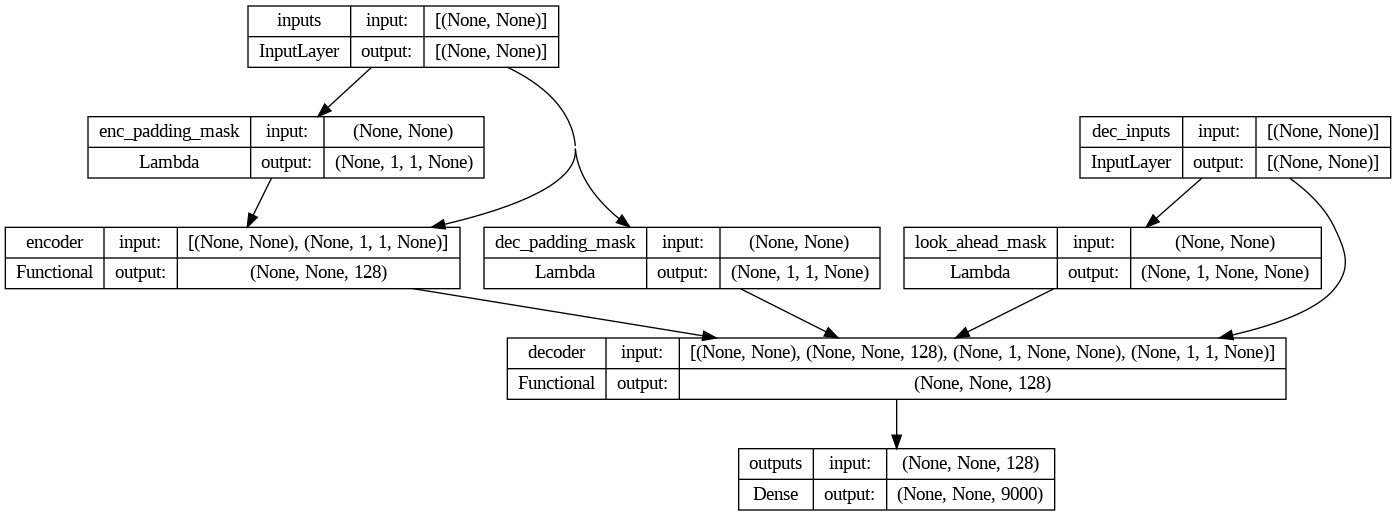

In [20]:
small_transformer = transformer(
    vocab_size = 9000,
    num_layers = 4,
    dff = 512,
    d_model = 128,
    num_heads = 4,
    dropout = 0.3,
    name="small_transformer")

tf.keras.utils.plot_model(
    small_transformer, to_file='small_transformer.png', show_shapes=True)


### 손실 함수 정의하기
다중 클래스 분류 문제를 풀 예정이므로 크로스 엔트로피 함수를 손실 함수로 정의합니다.

In [21]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)


### 학습률
학습률 스케줄러(Learning rate Scheduler)는 미리 학습 일정을 정해두고 그 일정에 따라 학습률이 조정되는 방법입니다. 트랜스포머의 경우 사용자가 정한 단계까지는 학습률을 증가시켰다가 단계에 이르면 학습률을 점차적으로 떨어트리는 방식을 사용합니다. 좀 더 구체적으로 봅시다. step_num(단계)이란 옵티마이저가 매개변수를 업데이트 하는 한 번의 진행 횟수를 의미합니다. 트랜스포머에서는 warmup_steps이라는 변수를 정하고 step_num이 warmup_steps보다 작을 경우는 학습률을 선형적으로 증가 시키고, step_num이 warmup_steps에 도달하게 되면 학습률을 step_num의 역제곱근에 따라서 감소시킵니다. 이를 식으로 표현하면 아래와 같습니다. warmup_steps의 값으로는 4,000을 사용하였습니다.

In [22]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)
    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


Text(0.5, 0, 'Train Step')

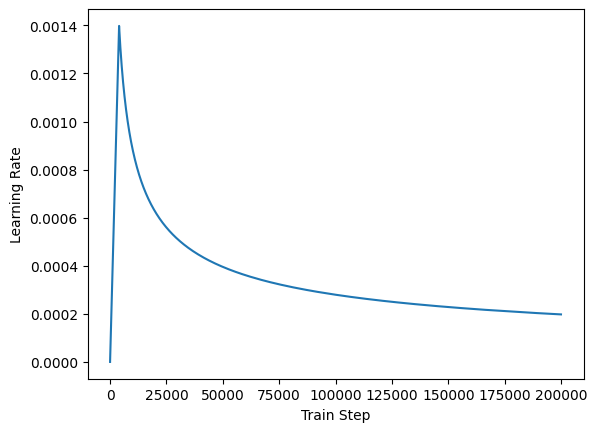

In [23]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")


### 데이터 로드하기

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
import time
import tensorflow_datasets as tfds
import tensorflow as tf


챗봇 데이터를 로드하여 상위 5개의 샘플을 출력해봅시다.

In [25]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv", filename="ChatBotData.csv")
train_data = pd.read_csv('ChatBotData.csv')
train_data.head()


,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


이 데이터는 질문(Q)과 대답(A)의 쌍으로 이루어진 데이터입니다.

In [26]:
print('챗봇 샘플의 개수 :', len(train_data))


챗봇 샘플의 개수 : 11823


총 샘플의 개수는 11,823개입니다. 불필요한 Null 값이 있는지 확인해봅시다.

In [27]:
print(train_data.isnull().sum())


Q        0
A        0
label    0
dtype: int64


Null 값은 별도로 존재하지 않습니다. 이번 실습에서는 토큰화를 위해 형태소 분석기를 사용하지 않고, 다른 방법인 학습 기반의 토크나이저를 사용할 것입니다. 그래서 원 데이터에서 ?, ., !와 같은 구두점을 미리 처리해두어야 하는데, 구두점들을 단순히 제거할 수도 있겠지만, 여기서는 구두점 앞에 공백. 즉, 띄어쓰기를 추가하여 다른 문자들과 구분하겠습니다.

가령, '12시 땡!' 이라는 문장이 있다면 '12시 땡 !'으로 땡과 !사이에 공백을 추가합니다. 이는 정규 표현식을 사용하여 가능합니다. 이 전처리는 질문 데이터와 답변 데이터 모두에 적용해줍니다.

In [28]:
questions = []
for sentence in train_data['Q']:
    # 구두점에 대해서 띄어쓰기
    # ex) 12시 땡! -> 12시 땡 !
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    questions.append(sentence)


In [29]:
answers = []
for sentence in train_data['A']:
    # 구두점에 대해서 띄어쓰기
    # ex) 12시 땡! -> 12시 땡 !
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    answers.append(sentence)


질문과 대답에 대해서 상위 5개만 출력하여 구두점들이 띄어쓰기를 통해 분리되었는지 확인해봅시다.

In [30]:
print(questions[:5])
print(answers[:5])


['12시 땡 !', '1지망 학교 떨어졌어', '3박4일 놀러가고 싶다', '3박4일 정도 놀러가고 싶다', 'PPL 심하네']
['하루가 또 가네요 .', '위로해 드립니다 .', '여행은 언제나 좋죠 .', '여행은 언제나 좋죠 .', '눈살이 찌푸려지죠 .']


'하루가 또 가네요 .'와 같이 구두점 앞에 띄어쓰기가 추가되어 분리된 것을 확인할 수 있습니다.

### 단어 집합 생성
앞서 서브워드 토크나이저 챕터에서 배웠던 서브워드텍스트인코더를 사용해봅시다. 자주 사용되는 서브워드 단위로 토큰을 분리하는 토크나이저로 학습 데이터로부터 학습하여 서브워드로 구성된 단어 집합을 생성합니다.

In [31]:
# 서브워드텍스트인코더를 사용하여 질문, 답변 데이터로부터 단어 집합(Vocabulary) 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    questions + answers, target_vocab_size=2**13)


단어 집합이 생성되었습니다. 그런데 seq2seq 챕터에서 배웠던 것처럼 인코더-디코더 모델 계열에는 디코더의 입력으로 사용할 시작을 의미하는 시작 토큰 SOS와 종료 토큰 EOS 또한 존재합니다. 해당 토큰들도 단어 집합에 포함시킬 필요가 있으므로 이 두 토큰에 정수를 부여해줍니다.

In [32]:
# 시작 토큰과 종료 토큰에 대한 정수 부여.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# 시작 토큰과 종료 토큰을 고려하여 단어 집합의 크기를 + 2
VOCAB_SIZE = tokenizer.vocab_size + 2


시작 토큰과 종료 토큰을 추가해주었으나 단어 집합의 크기도 +2를 해줍니다.
시작 토큰의 번호와 종료 토큰의 번호, 그리고 단어 집합의 크기를 출력해봅시다.

In [33]:
print('시작 토큰 번호 :',START_TOKEN)
print('종료 토큰 번호 :',END_TOKEN)
print('단어 집합의 크기 :',VOCAB_SIZE)


시작 토큰 번호 : [8178]
종료 토큰 번호 : [8179]
단어 집합의 크기 : 8180


패딩에 사용될 0번 토큰부터 마지막 토큰인 8,179번 토큰까지의 개수를 카운트하면 단어 집합의 크기는 8,180개입니다.

### 정수 인코딩과 패딩
단어 집합을 생성한 후에는 서브워드텍스트인코더의 토크나이저로 정수 인코딩을 진행할 수 있습니다. 이는 토크나이저의 .encode()를 사용하여 가능합니다. 우선 임의로 선택한 20번 질문 샘플. 즉, questions[20]을 가지고 정수 인코딩을 진행해봅시다.

In [34]:
# 서브워드텍스트인코더 토크나이저의 .encode()를 사용하여 텍스트 시퀀스를 정수 시퀀스로 변환.
print('임의의 질문 샘플을 정수 인코딩 : {}'.format(tokenizer.encode(questions[20])))


임의의 질문 샘플을 정수 인코딩 : [5766, 611, 3509, 141, 685, 3747, 849]


임의의 질문 문장이 정수 시퀀스로 변환되었습니다. 반대로 정수 인코딩 된 결과는 다시 decode()를 사용하여 기존의 텍스트 시퀀스로 복원할 수 있습니다. 20번 질문 샘플을 가지고 정수 인코딩하고, 다시 이를 디코딩하는 과정은 다음과 같습니다.

In [35]:
# 서브워드텍스트인코더 토크나이저의 .encode()와 .decode() 테스트해보기
# 임의의 입력 문장을 sample_string에 저장
sample_string = questions[20]

# encode() : 텍스트 시퀀스 --> 정수 시퀀스
tokenized_string = tokenizer.encode(sample_string)
print ('정수 인코딩 후의 문장 {}'.format(tokenized_string))

# decode() : 정수 시퀀스 --> 텍스트 시퀀스
original_string = tokenizer.decode(tokenized_string)
print ('기존 문장: {}'.format(original_string))


정수 인코딩 후의 문장 [5766, 611, 3509, 141, 685, 3747, 849]
기존 문장: 가스비 비싼데 감기 걸리겠어


정수 인코딩 된 문장을 .decode()을 하면 자동으로 서브워드들까지 다시 붙여서 기존 단어로 복원해줍니다. 가령, 정수 인코딩 문장을 보면 정수가 7개인데 기존 문장의 띄어쓰기 단위인 어절은 4개밖에 존재하지 않습니다. 이는 '가스비'나 '비싼데'라는 한 어절이 정수 인코딩 후에는 두 개 이상의 정수일 수 있다는 겁니다. 각 정수가 어떤 서브워드로 맵핑되는지 출력해봅시다.

In [36]:
# 각 정수는 각 단어와 어떻게 mapping되는지 병렬로 출력
# 서브워드텍스트인코더는 의미있는 단위의 서브워드로 토크나이징한다. 띄어쓰기 단위 X 형태소 분석 단위 X
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer.decode([ts])))


5766 ----> 가스
611 ----> 비 
3509 ----> 비싼
141 ----> 데 
685 ----> 감기 
3747 ----> 걸리
849 ----> 겠어


샘플 1개를 가지고 정수 인코딩과 디코딩을 수행해보았습니다. 이번에는 전체 데이터에 대해서 정수 인코딩과 패딩을 진행합니다. 이를 위한 함수로 tokenize_and_filter()를 만듭니다. 여기서는 임의로 패딩의 길이는 40으로 정했습니다.

In [37]:
# 최대 길이를 40으로 정의
MAX_LENGTH = 40

# 토큰화 / 정수 인코딩 / 시작 토큰과 종료 토큰 추가 / 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []

  for (sentence1, sentence2) in zip(inputs, outputs):
    # encode(토큰화 + 정수 인코딩), 시작 토큰과 종료 토큰 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    tokenized_inputs.append(sentence1)
    tokenized_outputs.append(sentence2)

  # 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

  return tokenized_inputs, tokenized_outputs


In [38]:
questions, answers = tokenize_and_filter(questions, answers)


정수 인코딩과 패딩이 진행된 후의 데이터의 크기를 확인해봅시다.

In [39]:
print('질문 데이터의 크기(shape) :', questions.shape)
print('답변 데이터의 크기(shape) :', answers.shape)


질문 데이터의 크기(shape) : (11823, 40)
답변 데이터의 크기(shape) : (11823, 40)


질문과 답변 데이터의 모든 문장이 모두 길이 40으로 변환되었습니다. 임의로 0번 샘플을 출력해봅시다.

In [40]:
# 0번 샘플을 임의로 출력
print(questions[0])
print(answers[0])


[8178 7915 4207 3060   41 8179    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
[8178 3844   74 7894    1 8179    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]


길이 40을 맞추기 위해 뒤에 0이 패딩된 것을 확인할 수 있습니다.

###인코더와 디코더의 입력, 그리고 레이블 만들기
tf.data.Dataset을 사용하여 데이터를 배치 단위로 불러올 수 있습니다.

In [41]:
# 텐서플로우 dataset을 이용하여 셔플(shuffle)을 수행하되, 배치 크기로 데이터를 묶는다.
# 또한 이 과정에서 교사 강요(teacher forcing)을 사용하기 위해서 디코더의 입력과 실제값 시퀀스를 구성한다.
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더의 실제값 시퀀스에서는 시작 토큰을 제거해야 한다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1] # 디코더의 입력. 마지막 패딩 토큰이 제거된다.
    },
    {
        'outputs': answers[:, 1:]  # 맨 처음 토큰이 제거된다. 다시 말해 시작 토큰이 제거된다.
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)


In [42]:
# 임의의 샘플에 대해서 [:, :-1]과 [:, 1:]이 어떤 의미를 가지는지 테스트해본다.
print(answers[0]) # 기존 샘플
print(answers[:1][:, :-1]) # 마지막 패딩 토큰 제거하면서 길이가 39가 된다.
print(answers[:1][:, 1:]) # 맨 처음 토큰이 제거된다. 다시 말해 시작 토큰이 제거된다. 길이는 역시 39가 된다.


[8178 3844   74 7894    1 8179    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
[[8178 3844   74 7894    1 8179    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]]
[[3844   74 7894    1 8179    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]]


### 트랜스 포머 만들기
이제 트랜스포머를 만들어봅시다. 하이퍼파라미터를 조정하여 실제 논문의 트랜스포머보다는 작은 모델을 만듭니다.
여기서 선택한 주요 하이퍼파라미터의 값은 다음과 같습니다.

In [43]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
D_MODEL = 256
NUM_LAYERS = 2
NUM_HEADS = 8
DFF = 512
DROPOUT = 0.1

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    dff=DFF,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)


(1, 8180, 256)
(1, 8180, 256)


학습률과 옵티마이저를 정의하고 모델을 컴파일합니다.

In [44]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  # 레이블의 크기는 (batch_size, MAX_LENGTH - 1)
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])


총 50회 모델을 학습합니다.

In [45]:
EPOCHS = 50
model.fit(dataset, epochs=EPOCHS)


Epoch 1/50
185/185 [==============================] - 62s 270ms/step - loss: 1.4490 - accuracy: 0.0320
Epoch 2/50
185/185 [==============================] - 50s 270ms/step - loss: 1.1743 - accuracy: 0.0495
Epoch 3/50
185/185 [==============================] - 50s 270ms/step - loss: 1.0014 - accuracy: 0.0508
Epoch 4/50
185/185 [==============================] - 50s 270ms/step - loss: 0.9273 - accuracy: 0.0545
Epoch 5/50
185/185 [==============================] - 50s 270ms/step - loss: 0.8713 - accuracy: 0.0574
Epoch 6/50
185/185 [==============================] - 50s 270ms/step - loss: 0.8130 - accuracy: 0.0614
Epoch 7/50
185/185 [==============================] - 50s 269ms/step - loss: 0.7481 - accuracy: 0.0671
Epoch 8/50
185/185 [==============================] - 50s 269ms/step - loss: 0.6757 - accuracy: 0.0749
Epoch 9/50
185/185 [==============================] - 50s 270ms/step - loss: 0.5973 - accuracy: 0.0837
Epoch 10/50
185/185 [==============================] - 50s 270ms/step - l

### 챗봇 평가하기.
챗봇을 평가하기 위한 세 개의 함수를 구현합니다. predict 함수에서 evaluate 함수를 호출하고 evaluate 함수에서 preprocess_sentence 함수를 호출하는 구조입니다. 사용자의 입력이 파이썬의 문자열로 입력되면 preprocess_sentence 함수에서 문자열에 대한 전처리를 수행합니다. 해당 전처리는 학습 전 질문 데이터와 답변 데이터에서 했던 전처리와 동일한 전처리입니다. 전처리가 진행된 문자열에 대해서 evaluate 함수는 트랜스포머 모델에 전처리가 진행된 사용자의 입력을 전달하고, 디코더를 통해 계속해서 현재 시점의 예측. 다시 말해 챗봇의 대답에 해당하는 단어를 순차적으로 예측합니다. 여기서 예측된 단어들은 문자열이 아니라 정수인 상태이므로 evaluate 함수가 리턴하는 것은 결과적으로 정수 시퀀스입니다. predict 함수는 evaluate 함수로부터 전달받은 챗봇의 대답에 해당하는 정수 시퀀스를 문자열로 다시 디코딩을 하고 사용자에게 챗봇의 대답을 출력합니다.

In [46]:
def preprocess_sentence(sentence):
  # 단어와 구두점 사이에 공백 추가.
  # ex) 12시 땡! -> 12시 땡 !
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = sentence.strip()
  return sentence


In [47]:
def evaluate(sentence):
  # 입력 문장에 대한 전처리
  sentence = preprocess_sentence(sentence)

  # 입력 문장에 시작 토큰과 종료 토큰을 추가
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  output = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 예측 시작
  for i in range(MAX_LENGTH):
    predictions = model(inputs=[sentence, output], training=False)

    # 현재 시점의 예측 단어를 받아온다.
    predictions = predictions[:, -1:, :]
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 시점의 예측 단어가 종료 토큰이라면 예측을 중단
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 현재 시점의 예측 단어를 output(출력)에 연결한다.
    # output은 for문의 다음 루프에서 디코더의 입력이 된다.
    output = tf.concat([output, predicted_id], axis=-1)

  # 단어 예측이 모두 끝났다면 output을 리턴.
  return tf.squeeze(output, axis=0)


In [48]:
def predict(sentence):
  prediction = evaluate(sentence)

  # prediction == 디코더가 리턴한 챗봇의 대답에 해당하는 정수 시퀀스
  # tokenizer.decode()를 통해 정수 시퀀스를 문자열로 디코딩.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('Input: {}'.format(sentence))
  print('Output: {}'.format(predicted_sentence))

  return predicted_sentence


학습된 트랜스포머에 임의로 생각나는 말들을 적어보았습니다.

In [49]:
output = predict("영화 볼래?")


Input: 영화 볼래?
Output: 최신 영화가 좋을 것 같아요 .


In [50]:
output = predict("고민이 있어")


Input: 고민이 있어
Output: 제가 �위치가 안돼요 .


In [51]:
output = predict("너무 화가나")


Input: 너무 화가나
Output: 그럴수록 당신이 힘들 거예요 .


In [52]:
output = predict("카페갈래?")


Input: 카페갈래?
Output: 애정표현일 지도 몰라요 .


In [53]:
output = predict("게임하고싶당")


Input: 게임하고싶당
Output: 이제 일어날 시간이에요 .


In [54]:
output = predict("게임하자")


Input: 게임하자
Output: 게임하세요 !
